***author: Bruno Guimarães de Oliveira***
***

#### Objectives:
- Create a model to forecast the quantity sold for each product given a prescribed price.

### Importing packages

In [444]:
#Data wrangling
import pandas as pd
import numpy as np

#Data Visualization
import matplotlib.pyplot as plt
from pylab import rcParams
import seaborn as sns

#Configurations
%matplotlib inline
plt.style.use('fivethirtyeight')
rcParams['figure.figsize'] = 16, 8
pd.options.display.max_rows=999
pd.set_option('display.float_format', lambda x: '%.3f' % x)

#Statistical and Time series analysis
from scipy import stats
from statsmodels.tsa.stattools import adfuller, acf, pacf
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import statsmodels.formula.api as smf
import statsmodels.tsa.api as smt
import statsmodels.api as sm
from scipy.stats import norm, skew
from scipy.special import boxcox1p
from pandas.plotting import autocorrelation_plot
from pandas.plotting import lag_plot

#Machine Learning
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score, SCORERS
from sklearn.linear_model import LinearRegression, Lasso
from sklearn.ensemble import RandomForestRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.svm import SVR
from sklearn.preprocessing import RobustScaler
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import TimeSeriesSplit, cross_val_score
import xgboost as xgb
import lightgbm as lgb

#Operational System
import os

#Garbage collector
import gc
gc.enable()

#Filtering warnings
import warnings
warnings.filterwarnings('ignore')

### Reading data

Our first dataset sales.csv contains transactional information where each line represents a sale.

Features description:
- ***PROD_ID:** Product ID. (P1 to P9)
- ***DATE_ORDER:** Sales Date.
- ***QTY_ORDER:** Quantity sold. (Target)
- ***REVENUE:** Sale Revenue.

In [2]:
file_path = '../data/test_prc/'

In [3]:
sales = pd.read_csv(file_path + 'sales.csv', parse_dates=['DATE_ORDER'])

In [4]:
sales.head()

,PROD_ID,DATE_ORDER,QTY_ORDER,REVENUE
0,P6,2015-08-02,1.000,1808.990
1,P6,2015-08-17,1.000,1674.000
2,P6,2015-08-17,1.000,1673.950
3,P6,2015-08-11,1.000,1674.000
4,P6,2015-08-17,1.000,1674.000


In [5]:
sales.shape

(351091, 4)

This dataset contains data of competitors' prices.

Features description:

- ***DATE_EXTRACTION:*** Date and Time of the extraction of the competitors' price.
- ***PROD_ID:*** Product ID. (Same as the sales dataset)
- ***COMPETITOR:*** Competitors' ID. (C1 to C6)
- ***COMPETITOR_PRICE:*** Competitor's price per product, which can depend on the payment method.
- ***PAY_TYPE:*** Payment Method. (1=deferred payment, 2=immediate payment)

In [6]:
prices = pd.read_csv(file_path + 'comp_prices.csv', parse_dates=['DATE_EXTRACTION'])

In [7]:
prices.head()

,PROD_ID,DATE_EXTRACTION,COMPETITOR,COMPETITOR_PRICE,PAY_TYPE
0,P6,2015-01-30 08:11:38,C3,1898.000,1
1,P6,2015-01-30 08:11:38,C1,1898.000,1
2,P6,2015-01-30 08:11:38,C6,1999.900,1
3,P6,2015-01-31 20:10:14,C2,1894.880,2
4,P6,2015-01-31 20:10:14,C3,1894.880,2


In [8]:
prices.shape

(50114, 5)

Now we normalize the columns putting all in lowercase, put the date feature on index and them sort the index of both datasets:

In [9]:
sales.columns = sales.columns.str.lower()
prices.columns = prices.columns.str.lower()

sales.set_index(sales['date_order'], inplace=True)
sales.drop('date_order', axis=1, inplace=True)
prices.set_index(prices['date_extraction'], inplace=True)
prices.drop('date_extraction', axis=1, inplace=True)

sales.sort_index(inplace=True)
prices.sort_index(inplace=True)

In [10]:
# convert_features(sales)
# convert_features(prices, 'prices')

First things first, we start by analysing the sales dataset to see if we can find some knowledge from there, then we pass to the competitors' prices dataset and finally we figure out a way of join both of datasets (probably we join then by prod_id, because is the only feature in common) and search for some correlations on the data. 

Let's give a first look on sales data.

In [11]:
prices.head()

,prod_id,competitor,competitor_price,pay_type
date_extraction,,,,
2015-01-01 08:10:25,P7,C4,799.000,1
2015-01-01 08:10:25,P6,C6,2799.900,1
2015-01-01 08:10:25,P6,C1,1959.900,1
2015-01-01 08:10:25,P6,C3,1914.900,1
2015-01-01 08:10:25,P6,C1,1959.900,2


In [12]:
print('Sales date range from {} to {}'.format(sales.index.min(), sales.index.max()))
print("Competitors' prices date range from {} to {}".format(prices.index.min(), prices.index.max()))

Sales date range from 2015-01-01 00:00:00 to 2015-10-14 00:00:00
Competitors' prices date range from 2015-01-01 08:10:25 to 2015-10-14 20:11:30


In [13]:
print('Total of sales: {}'.format(sales.shape[0]))
print('Total of prices: {}'.format(prices.shape[0]))

Total of sales: 351091
Total of prices: 50114


Let's first check for null values on datasets.

In [14]:
sales.isnull().sum().to_frame('Null values')

,Null values
prod_id,0
qty_order,0
revenue,0


In [15]:
prices.isnull().sum().to_frame('Null values')

,Null values
prod_id,0
competitor,0
competitor_price,0
pay_type,0


There are no null values for us to deal with so we can continue.

Some basic statistics of the dataset as well.

In [16]:
sales.describe()

,qty_order,revenue
count,351091.000,351091.000
mean,1.079,764.954
std,1.104,781.957
min,1.000,229.000
25%,1.000,649.000
50%,1.000,749.000
75%,1.000,799.000
max,500.000,368750.000


We can see that qty_order of 500 is a possible outlier, let's investigate it further.

In [17]:
sales[sales['qty_order'] == sales['qty_order'].max()]

,prod_id,qty_order,revenue
date_order,,,
2015-06-25,P7,500.000,368750.000


I pretty sure that this value is an outlier because all percentiles are equal to one and the mean is slighted higher than the median, so let's drop this row, since it's just one row I think it won't prejudicate our analysis.

In [18]:
sales.drop(sales[sales['qty_order'] == sales['qty_order'].max()].index, axis=0, inplace=True)

In [19]:
prices.describe()

,competitor_price,pay_type
count,50114.000,50114.000
mean,1111.281,1.500
std,3805.613,0.500
min,359.100,1.000
25%,549.000,1.000
50%,799.000,1.000
75%,1359.000,2.000
max,149900.000,2.000


And there's several outliers of value 149900.000 that I will remove to continue my analysis.

In [20]:
prices[prices['competitor_price'] == prices['competitor_price'].max()]

,prod_id,competitor,competitor_price,pay_type
date_extraction,,,,
2015-10-14 08:11:39,P1,C2,149900.000,2
2015-10-14 08:11:39,P1,C3,149900.000,1
2015-10-14 08:11:39,P1,C5,149900.000,1
2015-10-14 08:11:39,P6,C6,149900.000,2
2015-10-14 08:11:39,P6,C6,149900.000,1
2015-10-14 08:11:39,P1,C2,149900.000,1
2015-10-14 08:11:39,P1,C1,149900.000,1


In [21]:
prices.drop(prices[prices['competitor_price'] == prices['competitor_price'].max()].index, axis=0, inplace=True)

Let's analyse the quantity of sales and mean of revenue per product to see what product gives more sales and more rentable.

In [22]:
sales_per_item = sales.groupby(['prod_id'])['qty_order'].sum().to_frame()
sales_per_item.sort_values(by='prod_id', ascending=True, inplace=True)

revenue_per_item = sales.groupby(['prod_id'])['revenue'].mean().to_frame()
revenue_per_item.sort_values(by='prod_id', ascending=True, inplace=True)

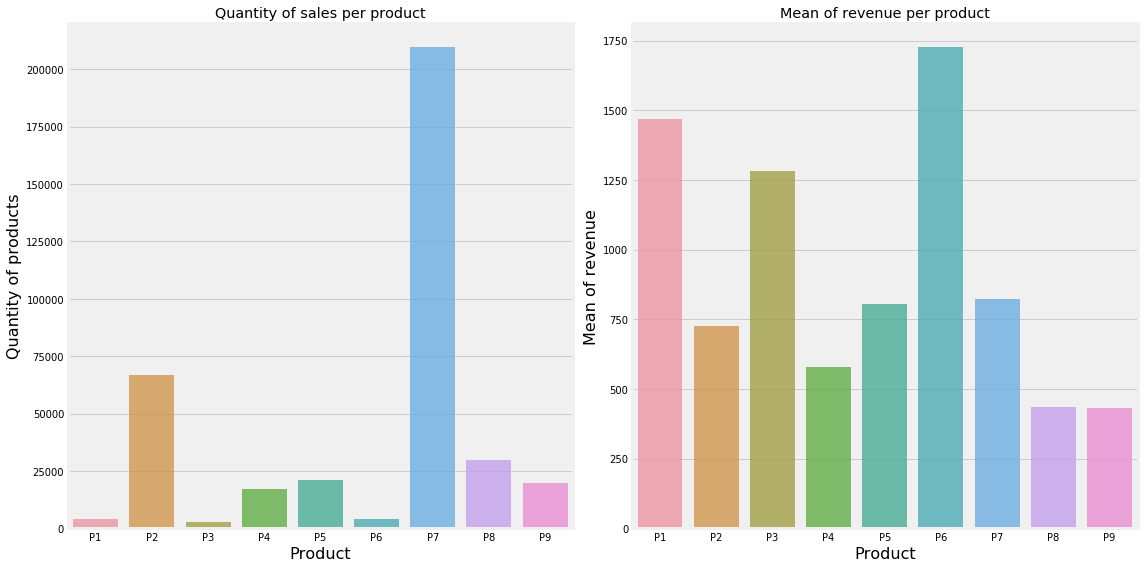

In [23]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(16, 8))

sns.barplot(sales_per_item.index, sales_per_item['qty_order'], alpha=0.8, ax=ax[0])
ax[0].set_title('Quantity of sales per product')
ax[0].set_xlabel('Product', fontsize=16)
ax[0].set_ylabel('Quantity of products', fontsize=16)

sns.barplot(revenue_per_item.index, revenue_per_item['revenue'], alpha=0.8, ax=ax[1])
ax[1].set_title('Mean of revenue per product')
ax[1].set_xlabel('Product', fontsize=16)
ax[1].set_ylabel('Mean of revenue', fontsize=16)

plt.tight_layout();

We can see that product P7 is the one that sales the most but is not the one with the biggest revenue, this one is the product P6 which is one of the lowests products that has been sold on this period. 

So it gives us that product P6 is the more expensive product we have for sale together with product P1 and P3, which are the top 3 products with more revenue and lowest quantity of sales.

If I can suggest something, just based on these graphs, is to start to sales more products P1, P3 and P6 since it's the most expensive products we have.

In [24]:
prices.head()

,prod_id,competitor,competitor_price,pay_type
date_extraction,,,,
2015-01-01 08:10:25,P7,C4,799.000,1
2015-01-01 08:10:25,P6,C6,2799.900,1
2015-01-01 08:10:25,P6,C1,1959.900,1
2015-01-01 08:10:25,P6,C3,1914.900,1
2015-01-01 08:10:25,P6,C1,1959.900,2


In [25]:
prices_per_item = prices.groupby(['prod_id'])['competitor_price'].sum().to_frame()
prices_per_item.sort_values(by='prod_id', ascending=True, inplace=True)

prices_per_competitor = prices.groupby(['competitor'])['competitor_price'].sum().to_frame()
prices_per_competitor.sort_values(by='competitor', ascending=True, inplace=True)

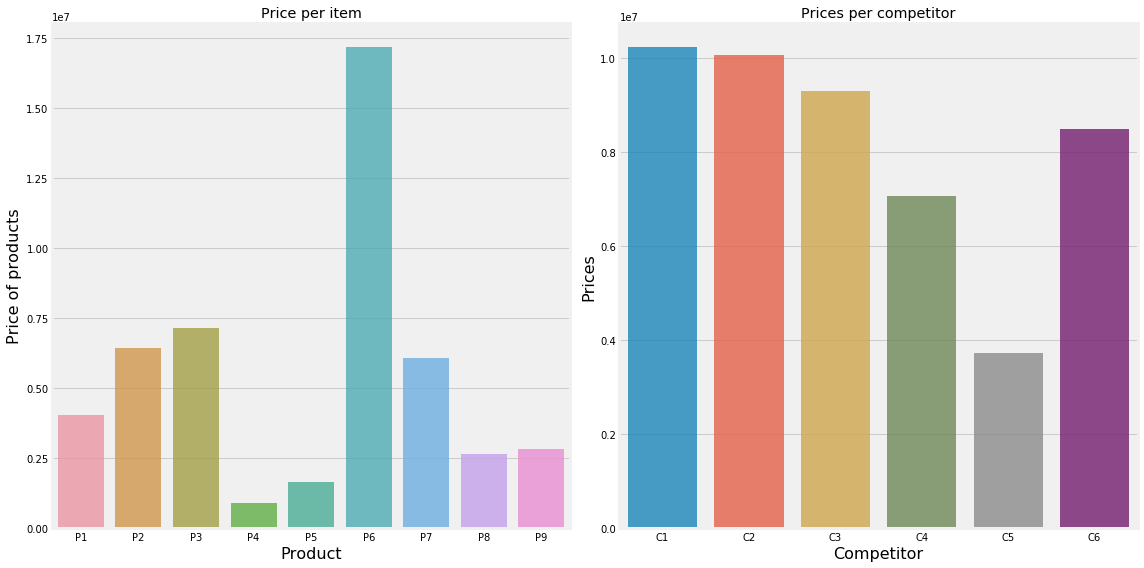

In [26]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(16, 8))

sns.barplot(prices_per_item.index, prices_per_item['competitor_price'], alpha=0.8, ax=ax[0])
ax[0].set_title('Price per item')
ax[0].set_xlabel('Product', fontsize=16)
ax[0].set_ylabel('Price of products', fontsize=16)

sns.barplot(prices_per_competitor.index, prices_per_competitor['competitor_price'], alpha=0.8, ax=ax[1])
ax[1].set_title('Prices per competitor')
ax[1].set_xlabel('Competitor', fontsize=16)
ax[1].set_ylabel('Prices', fontsize=16)

plt.tight_layout();

We can see that product P6 is the most expensive product that our competitors sell and that competitor C1 is the biggest competitor we have and C5 is the lowest.

The expensiveness of P6 is in agreement with our analysis of the sales dataset. P6 is in fact the more expensive product that us and our competitors' have.

The top 3 competetitors' with biggest prices was C3, C2 and the biggest C1.

In [27]:
competitors = prices['competitor'].sort_values().unique()
competitor_prod = prices.groupby(['competitor', 'prod_id']).mean()['competitor_price'].to_frame()

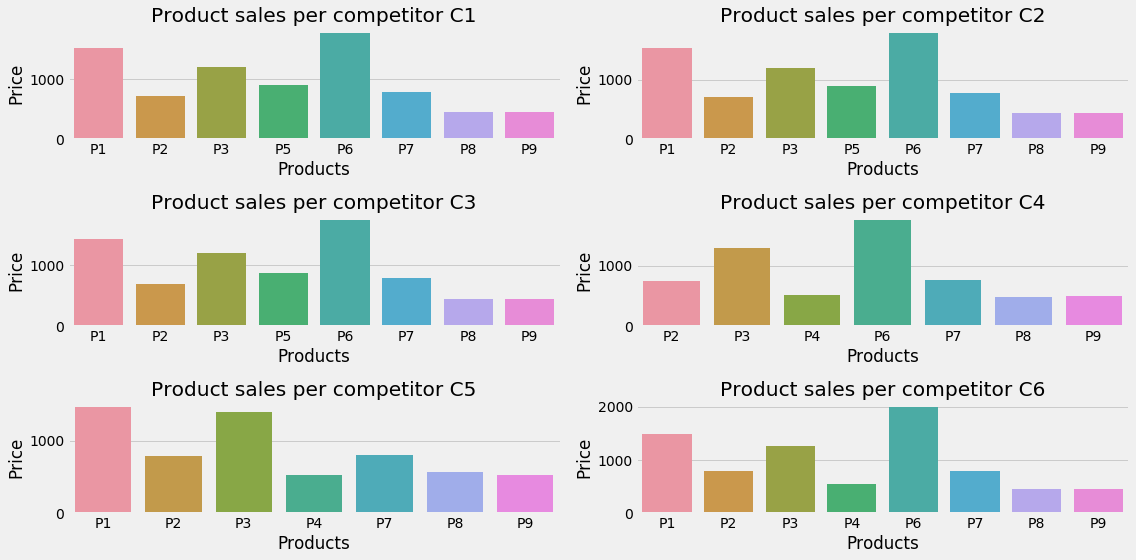

In [31]:
fig, ax = plt.subplots(nrows=3, ncols=2)

k = 0
for i in range(3):
    for j in range(2):
        sns.barplot(x=competitor_prod.loc[competitors[k]].index, y=competitor_prod.loc[competitors[k]]['competitor_price'], ax=ax[i, j])
        ax[i, j].set_title('Product sales per competitor {}'.format(competitors[k]))
        ax[i, j].set_xlabel('Products')
        ax[i, j].set_ylabel('Price')
        k+=1
        plt.tight_layout()

In [32]:
prod_price_per_pay_type = prices.groupby(['pay_type', 'prod_id']).mean()
competitor_price_per_pay_type = prices.groupby(['pay_type', 'competitor']).mean()
pay_type = [1, 2]

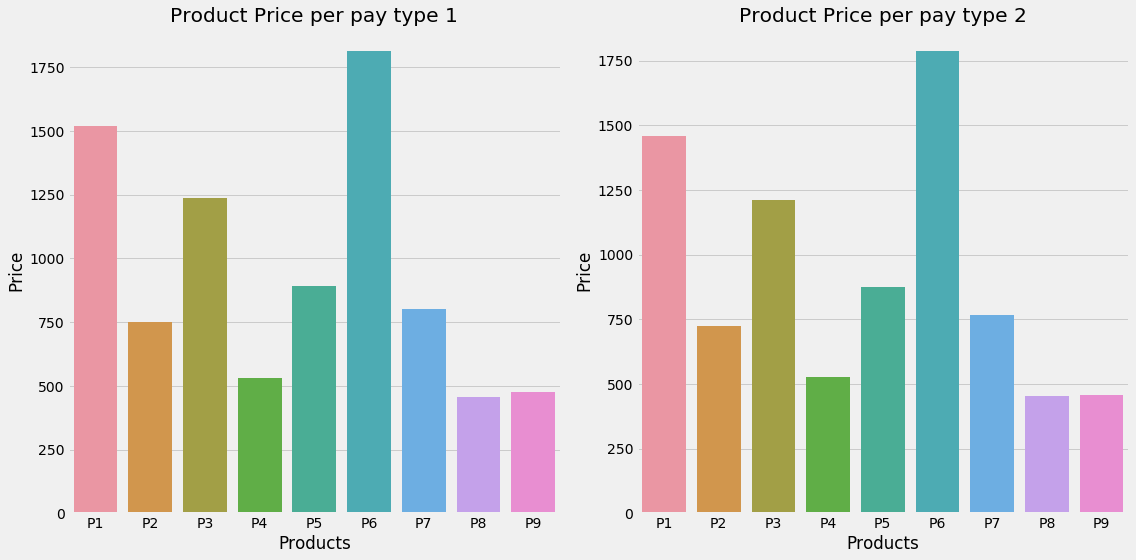

In [33]:
fig, ax = plt.subplots(nrows=1, ncols=2)

k = 0
for i in range(2):
    sns.barplot(x=prod_price_per_pay_type.loc[pay_type[k]].index, y=prod_price_per_pay_type.loc[pay_type[k]]['competitor_price'], ax=ax[i])
    ax[i].set_title('Product Price per pay type {}'.format(pay_type[k]))
    ax[i].set_xlabel('Products')
    ax[i].set_ylabel('Price')
    k+=1
    plt.tight_layout()

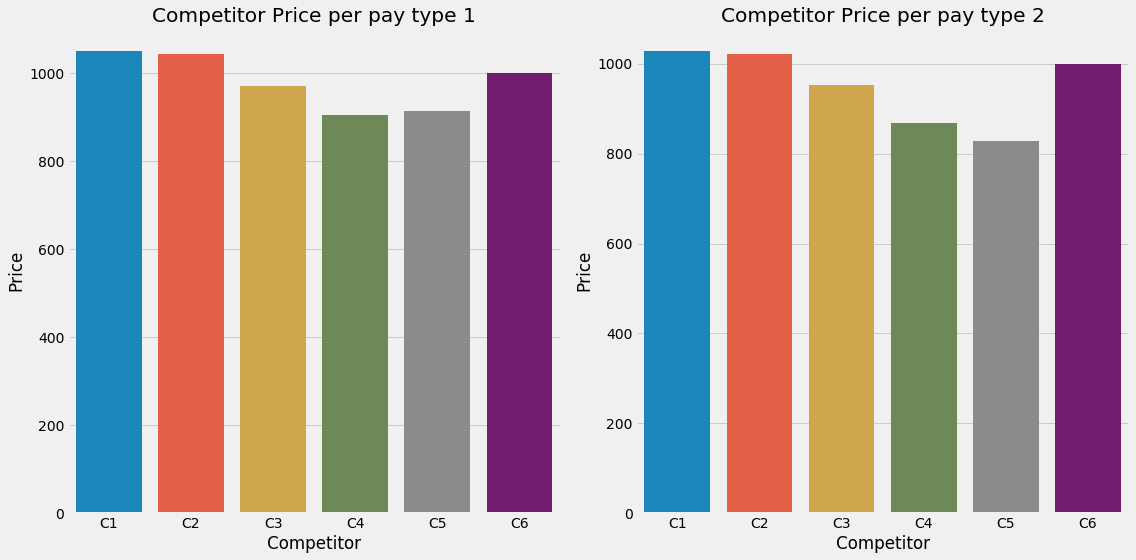

In [34]:
fig, ax = plt.subplots(nrows=1, ncols=2)

k = 0
for i in range(2):
    sns.barplot(x=competitor_price_per_pay_type.loc[pay_type[k]].index, y=competitor_price_per_pay_type.loc[pay_type[k]]['competitor_price'], ax=ax[i])
    ax[i].set_title('Competitor Price per pay type {}'.format(pay_type[k]))
    ax[i].set_xlabel('Competitor')
    ax[i].set_ylabel('Price')
    k+=1
    plt.tight_layout()

Let's give a look into the sold quantities of all products sales over time.

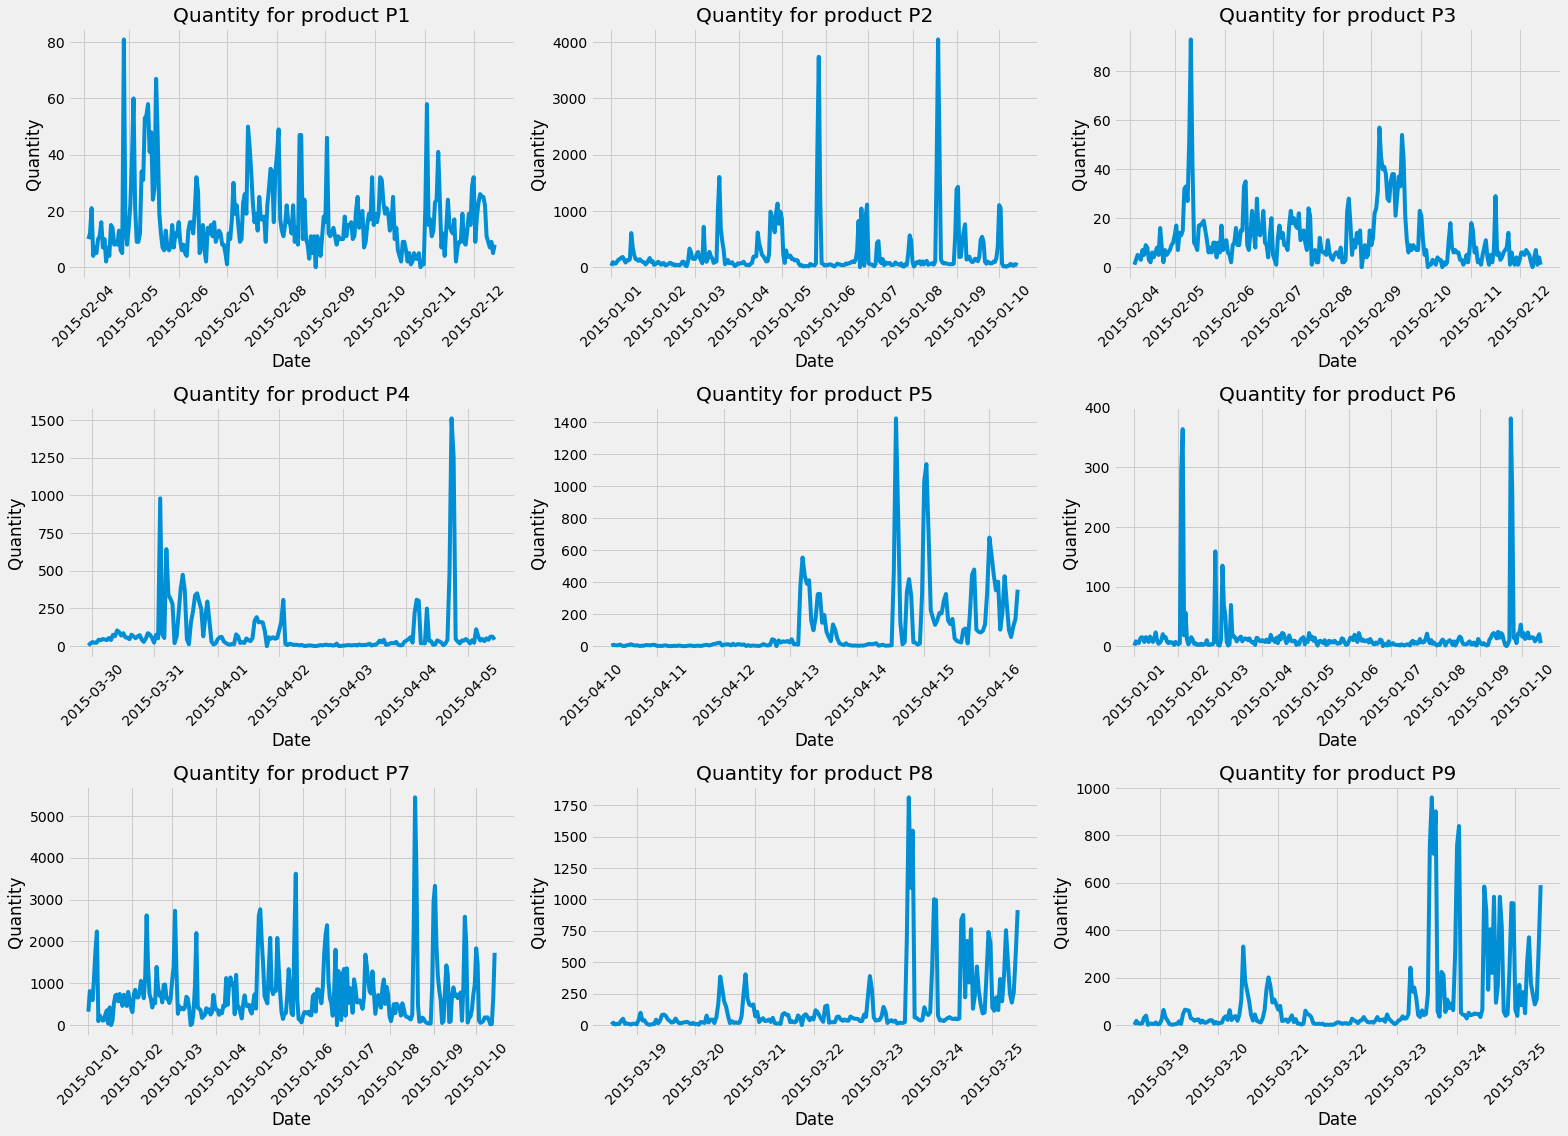

In [35]:
fig, ax = plt.subplots(nrows=3, ncols=3, figsize=(22, 16))

products = sales['prod_id'].sort_values().unique()
k = 0
for i in range(3):
    for j in range(3):
        ts = sales[sales['prod_id'] == products[k]]
        ts = ts.resample('D').sum()['qty_order']
        
        ax[i,j].plot(ts.index, ts)
        ax[i,j].set_title('Quantity for product {}'.format(products[k]))
        ax[i,j].set_xlabel('Date')
        ax[i,j].set_ylabel('Quantity')
        ax[i,j].set_xticklabels(ts.index.astype(str), rotation=45)
        
        k+=1
            
        plt.tight_layout()

We can see that the quantity of products sold by day for every product has several spikes that may represent outliers but all the series has constant mean but a non constant variance which represents a high volatility on sales.

And now on it's revenue

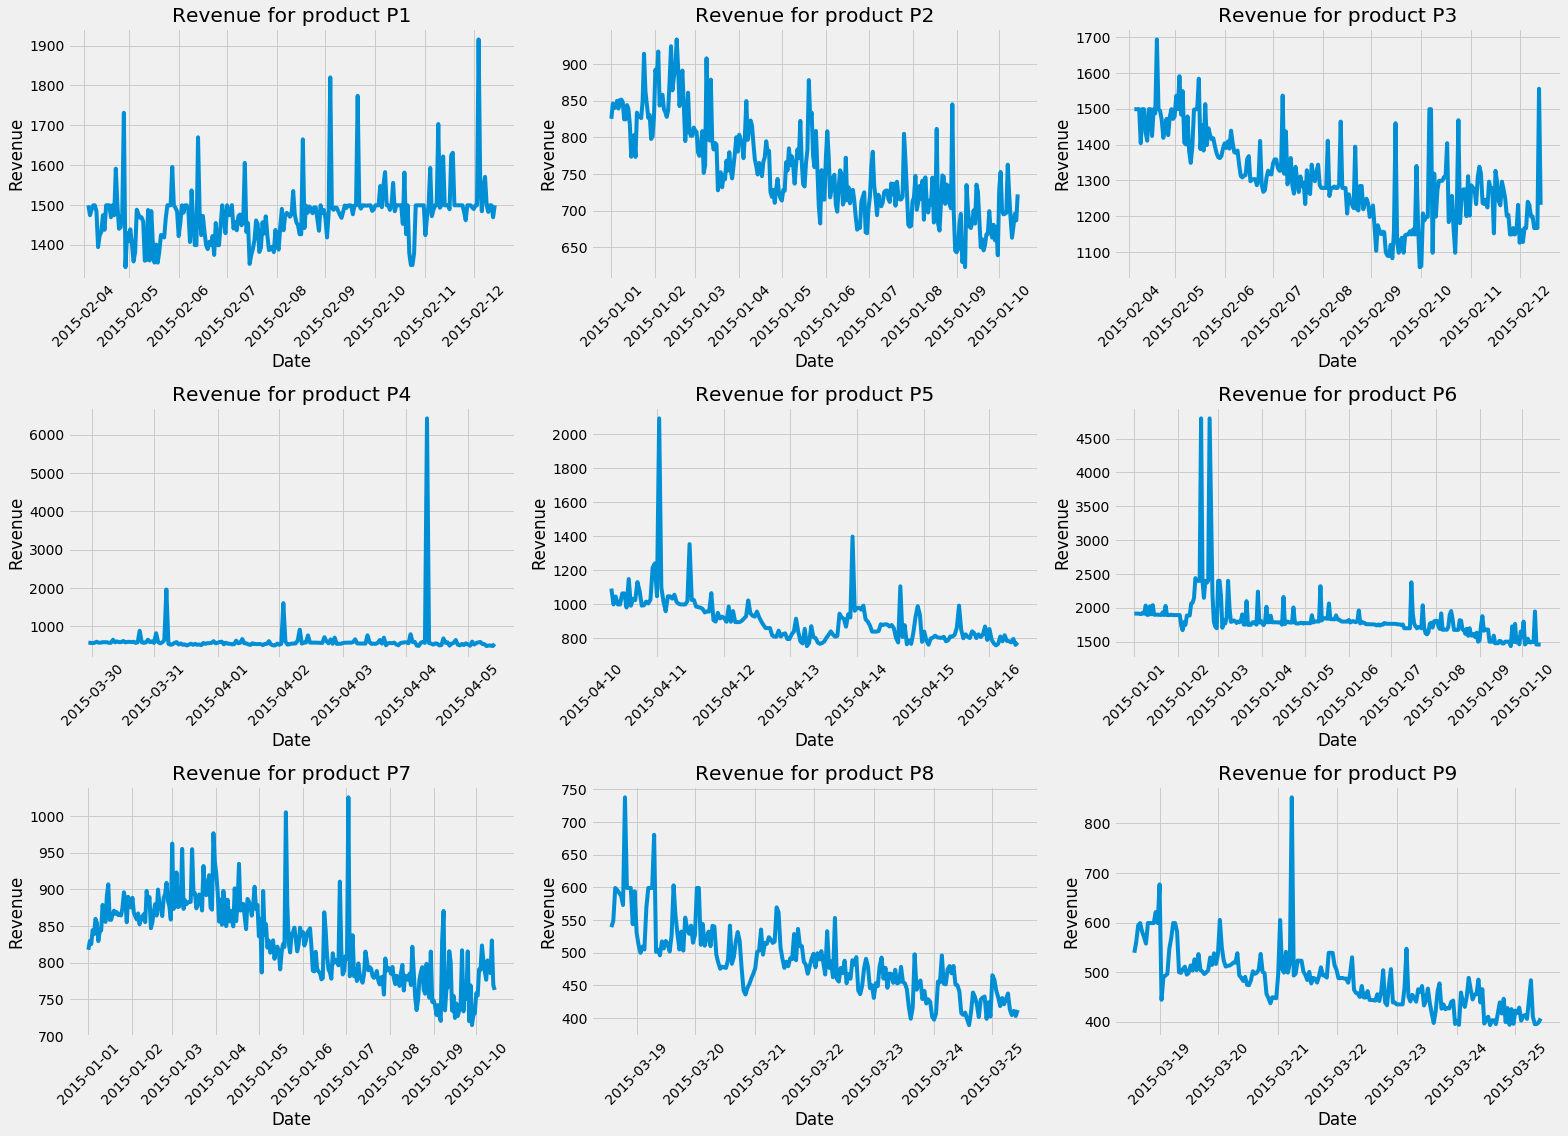

In [36]:
fig, ax = plt.subplots(nrows=3, ncols=3, figsize=(22, 16))

products = sales['prod_id'].sort_values().unique()
k = 0
for i in range(3):
    for j in range(3):
        ts = sales[sales['prod_id'] == products[k]]['revenue']
        ts = ts.resample('D').mean()
        ts.fillna(method='ffill', inplace=True)
        
        ax[i,j].plot(ts.index, ts)
        ax[i,j].set_title('Revenue for product {}'.format(products[k]))
        ax[i,j].set_xlabel('Date')
        ax[i,j].set_ylabel('Revenue')
        ax[i,j].set_xticklabels(ts.index.astype(str), rotation=45)

        k+=1
            
        plt.tight_layout()

The objective is to forecast the quantity of sales for each product. Sales over time for each product is a time series for itself so before we handle all of the products let's deal with only one ime series and try to undestand it.

In [37]:
p7 = sales[sales['prod_id'] == 'P7'][['qty_order', 'revenue']]

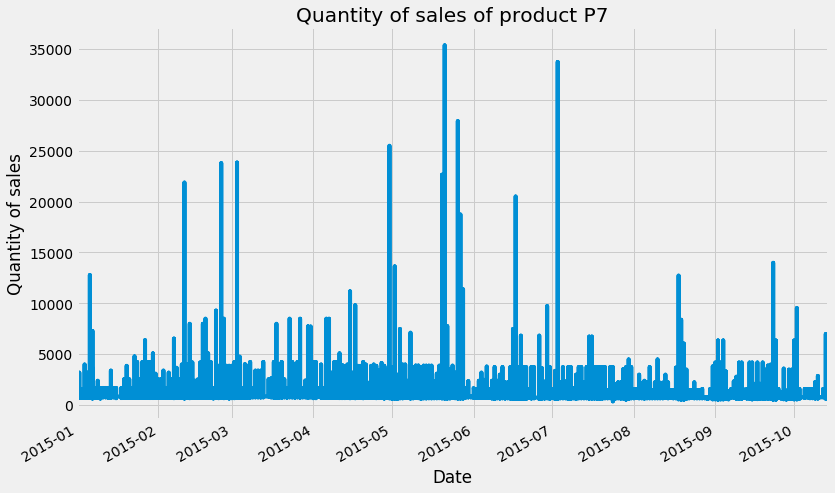

In [38]:
p7['revenue'].plot(figsize=(12, 8))
plt.title('Quantity of sales of product P7')
plt.xlabel('Date')
plt.ylabel('Quantity of sales');

Let's resample the time series per day to see it more clearly and plot it together with it's rolling mean and standart deviation.

In [39]:
def plot_ts(series, window, ax, plot_intervals=False, scale=1.96, plot_anomalies=False):

    """
        series - dataframe with timeseries
        window - rolling window size 
        plot_intervals - show confidence intervals
        plot_anomalies - show anomalies 

    """
    rolling_mean = series.rolling(window=window).mean()

    plt.figure(figsize=(15,5))
#     ax.set_title("Moving average\n window size = {}".format(window))
    ax.plot(rolling_mean, "g", label="Rolling mean trend")

    # Plot confidence intervals for smoothed values
    if plot_intervals:
        mae = mean_absolute_error(series[window:], rolling_mean[window:])
        deviation = np.std(series[window:] - rolling_mean[window:])
        lower_bond = rolling_mean - (mae + scale * deviation)
        upper_bond = rolling_mean + (mae + scale * deviation)
        ax.plot(upper_bond, "r--", label="Upper Bond / Lower Bond")
        ax.plot(lower_bond, "r--",)
        
        # Having the intervals, find abnormal values
        if plot_anomalies:
            anomalies = pd.DataFrame(index=series.index, columns=series.columns)
            anomalies[series<lower_bond] = series[series<lower_bond]
            anomalies[series>upper_bond] = series[series>upper_bond]
            ax.plot(anomalies, "ro", markersize=10)
        
    ax.plot(series[window:], label="Actual values")
    ax.legend(loc=0)
    ax.grid(True)
    ax.set_xticklabels(series.index.astype(str), rotation=45)
    plt.tight_layout()
    
    return plt

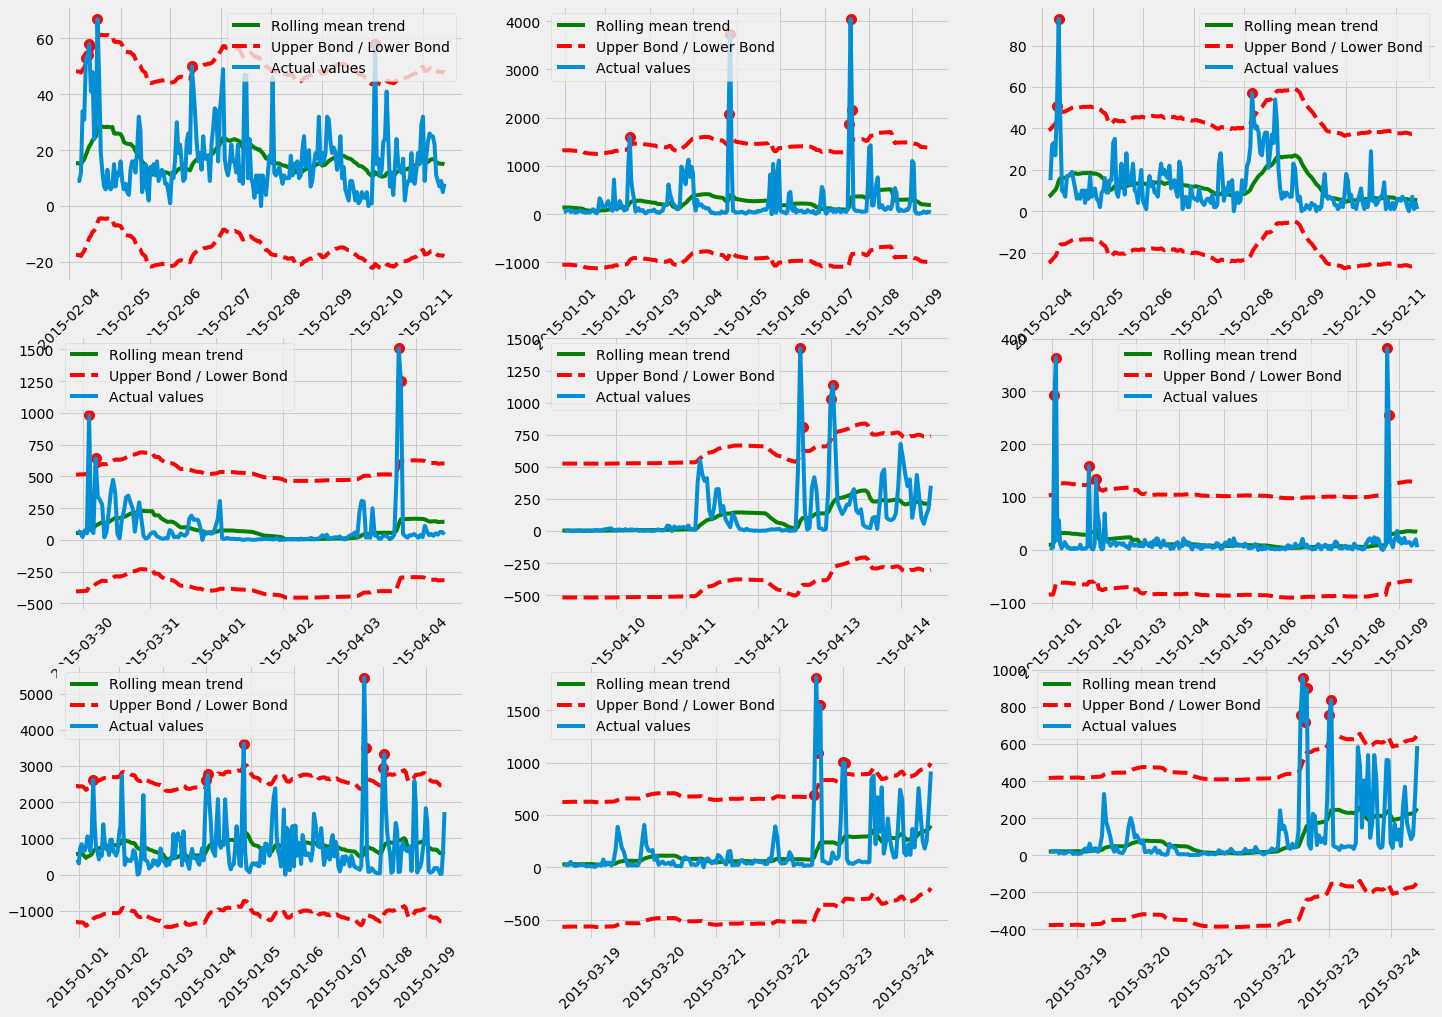

<Figure size 1080x360 with 0 Axes>

<Figure size 1080x360 with 0 Axes>

<Figure size 1080x360 with 0 Axes>

<Figure size 1080x360 with 0 Axes>

<Figure size 1080x360 with 0 Axes>

<Figure size 1080x360 with 0 Axes>

<Figure size 1080x360 with 0 Axes>

<Figure size 1080x360 with 0 Axes>

<Figure size 1080x360 with 0 Axes>

In [40]:
fig, ax = plt.subplots(nrows=3, ncols=3, figsize=(22, 16))

products = sales['prod_id'].sort_values().unique()
k = 0
for i in range(3):
    for j in range(3):
        ts = sales[sales['prod_id'] == products[k]]['qty_order']
        ts = ts.resample('D').sum()
        
        _ = plot_ts(ts.to_frame(), window=30, ax=ax[i,j], plot_intervals=True, plot_anomalies=True);

        k+=1

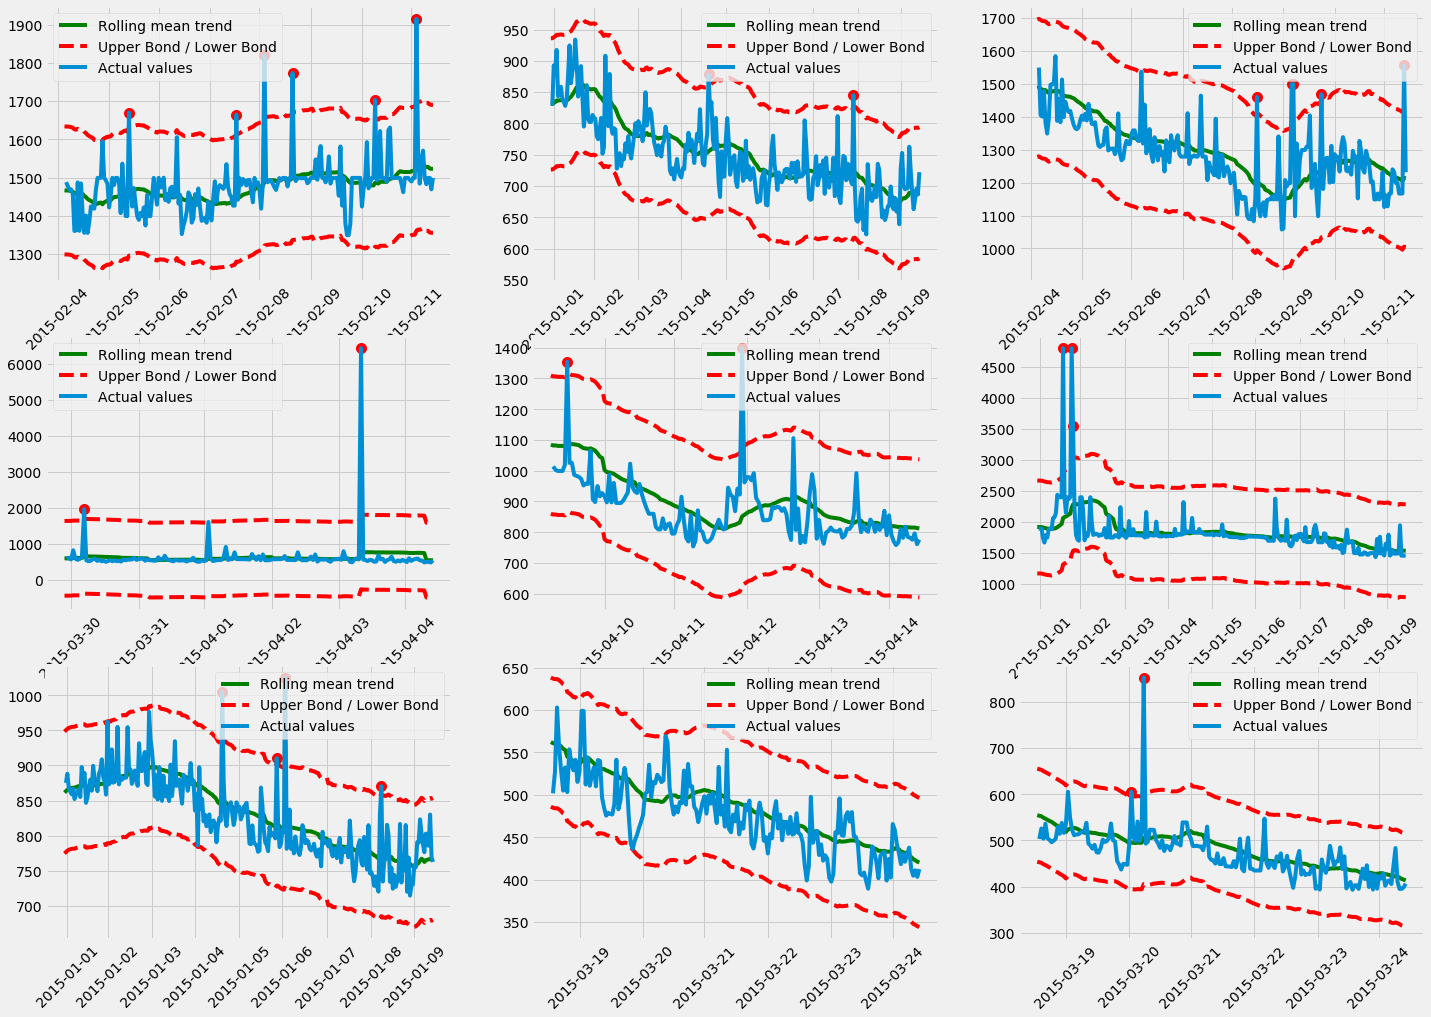

<Figure size 1080x360 with 0 Axes>

<Figure size 1080x360 with 0 Axes>

<Figure size 1080x360 with 0 Axes>

<Figure size 1080x360 with 0 Axes>

<Figure size 1080x360 with 0 Axes>

<Figure size 1080x360 with 0 Axes>

<Figure size 1080x360 with 0 Axes>

<Figure size 1080x360 with 0 Axes>

<Figure size 1080x360 with 0 Axes>

In [43]:
fig, ax = plt.subplots(nrows=3, ncols=3, figsize=(22, 16))

products = sales['prod_id'].sort_values().unique()
k = 0
for i in range(3):
    for j in range(3):
        ts = sales[sales['prod_id'] == products[k]]['revenue']
        ts = ts.resample('D').mean()
        ts.fillna(method='ffill', inplace=True)
        
        _ = plot_ts(ts.to_frame(), window=30, ax=ax[i,j], plot_intervals=True, plot_anomalies=True);

        k+=1

Let's decompose the time series for this product in trend, seasonality and residual components.

In [44]:
def decompose_ts(ts, freq=60, model='additive'):
    """
    This function decomposes a time series in a trend, seasonal and residual components and plots it's components.
    
    param ts: Time series data
    param freq: Frequency for decomposition
    param model: Model for the time series
    returns: It returns it's residual components.
    
    """
    res = sm.tsa.seasonal_decompose(ts.values, freq=freq, model=model)
    
    fig, ax = plt.subplots(nrows=2, ncols=2, figsize=(16, 8))
    ax[0,0].plot(ts.index, res.observed)
    ax[0,0].set_title('Original Time Series')
    ax[0,0].set_xticklabels(labels=ts.index.astype(str), rotation=45)
    ax[0,1].set_title('Trend')
    ax[0,1].plot(ts.index, res.trend)
    ax[0,1].set_xticklabels(labels=ts.index.astype(str), rotation=45)
    ax[1,0].plot(ts.index, res.seasonal)
    ax[1,0].set_title('Seasonality')
    ax[1,0].set_xticklabels(labels=ts.index.astype(str), rotation=45)
    ax[1,1].plot(ts.index, res.observed)
    ax[1,1].set_title('Residual')
    ax[1,1].set_xticklabels(labels=ts.index.astype(str), rotation=45)
    plt.tight_layout()
    
    return res

In [46]:
sales_per_day = p7.resample('D').agg({'qty_order': 'sum', 'revenue': 'mean'})

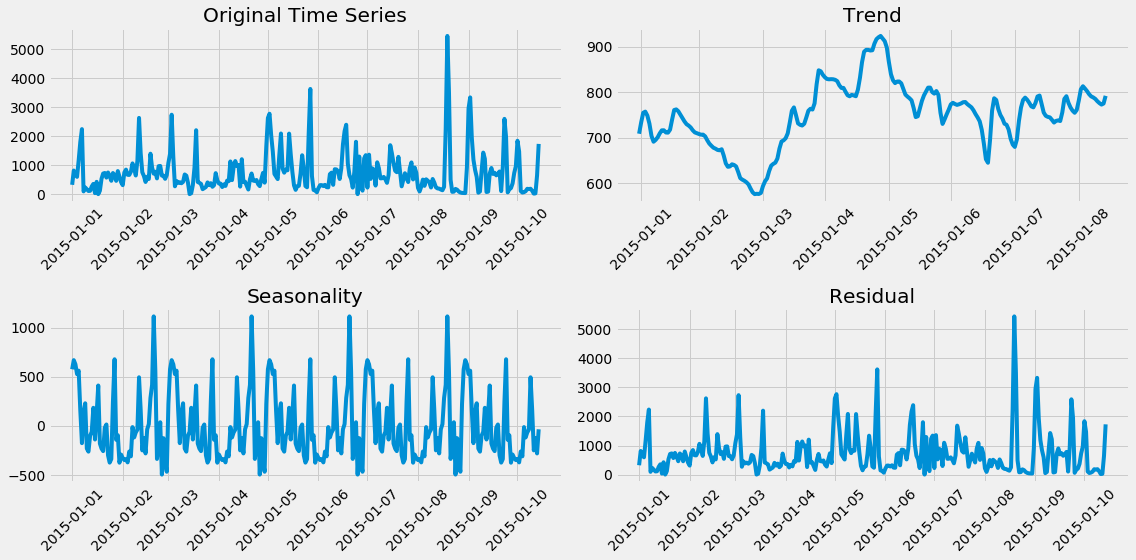

In [47]:
res = decompose_ts(sales_per_day['qty_order'])

The trend part of the time series don't give us a lot of information but we can see that don't exists a clear seasonality on our data, let's look it further by plotting the autocorrelation function.

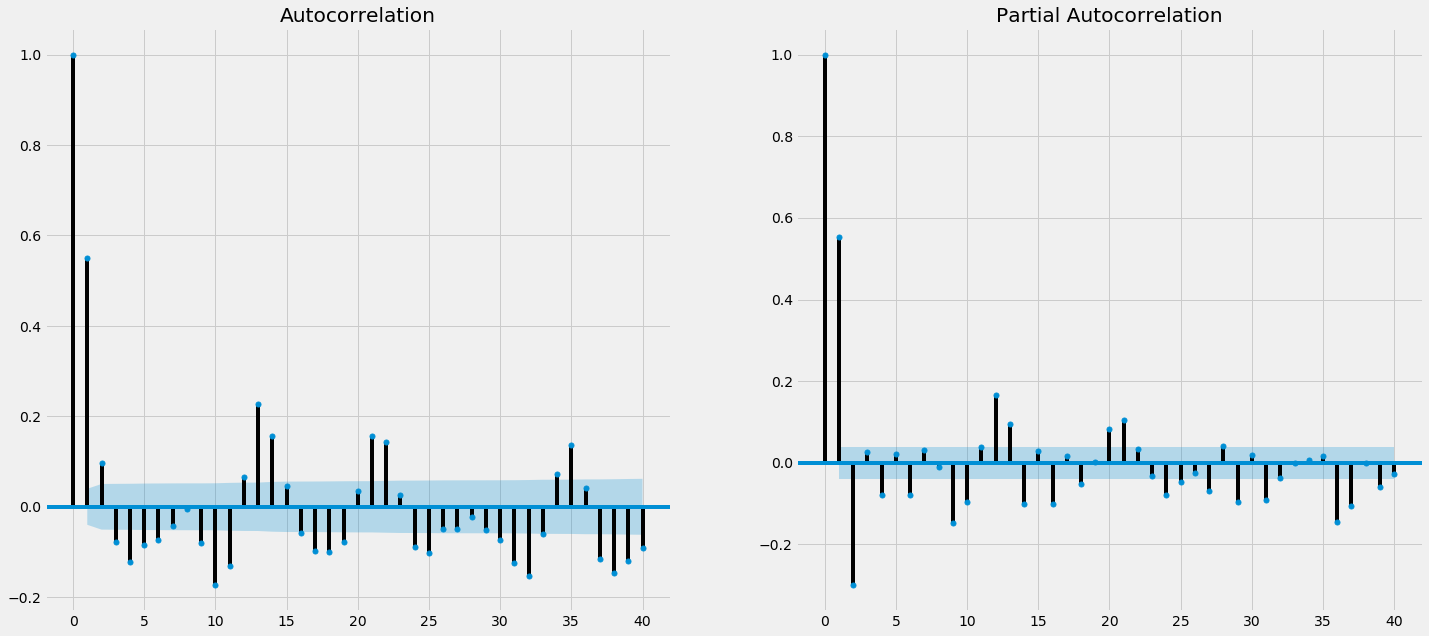

In [48]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(22, 10))

plot_acf(sales_per_day['qty_order'], lags=40, ax=ax[0], alpha=0.5)
plot_pacf(sales_per_day['qty_order'], lags=40, ax=ax[1], alpha=0.5);

Let's take a look on the data resample by month to see if we can some insights.

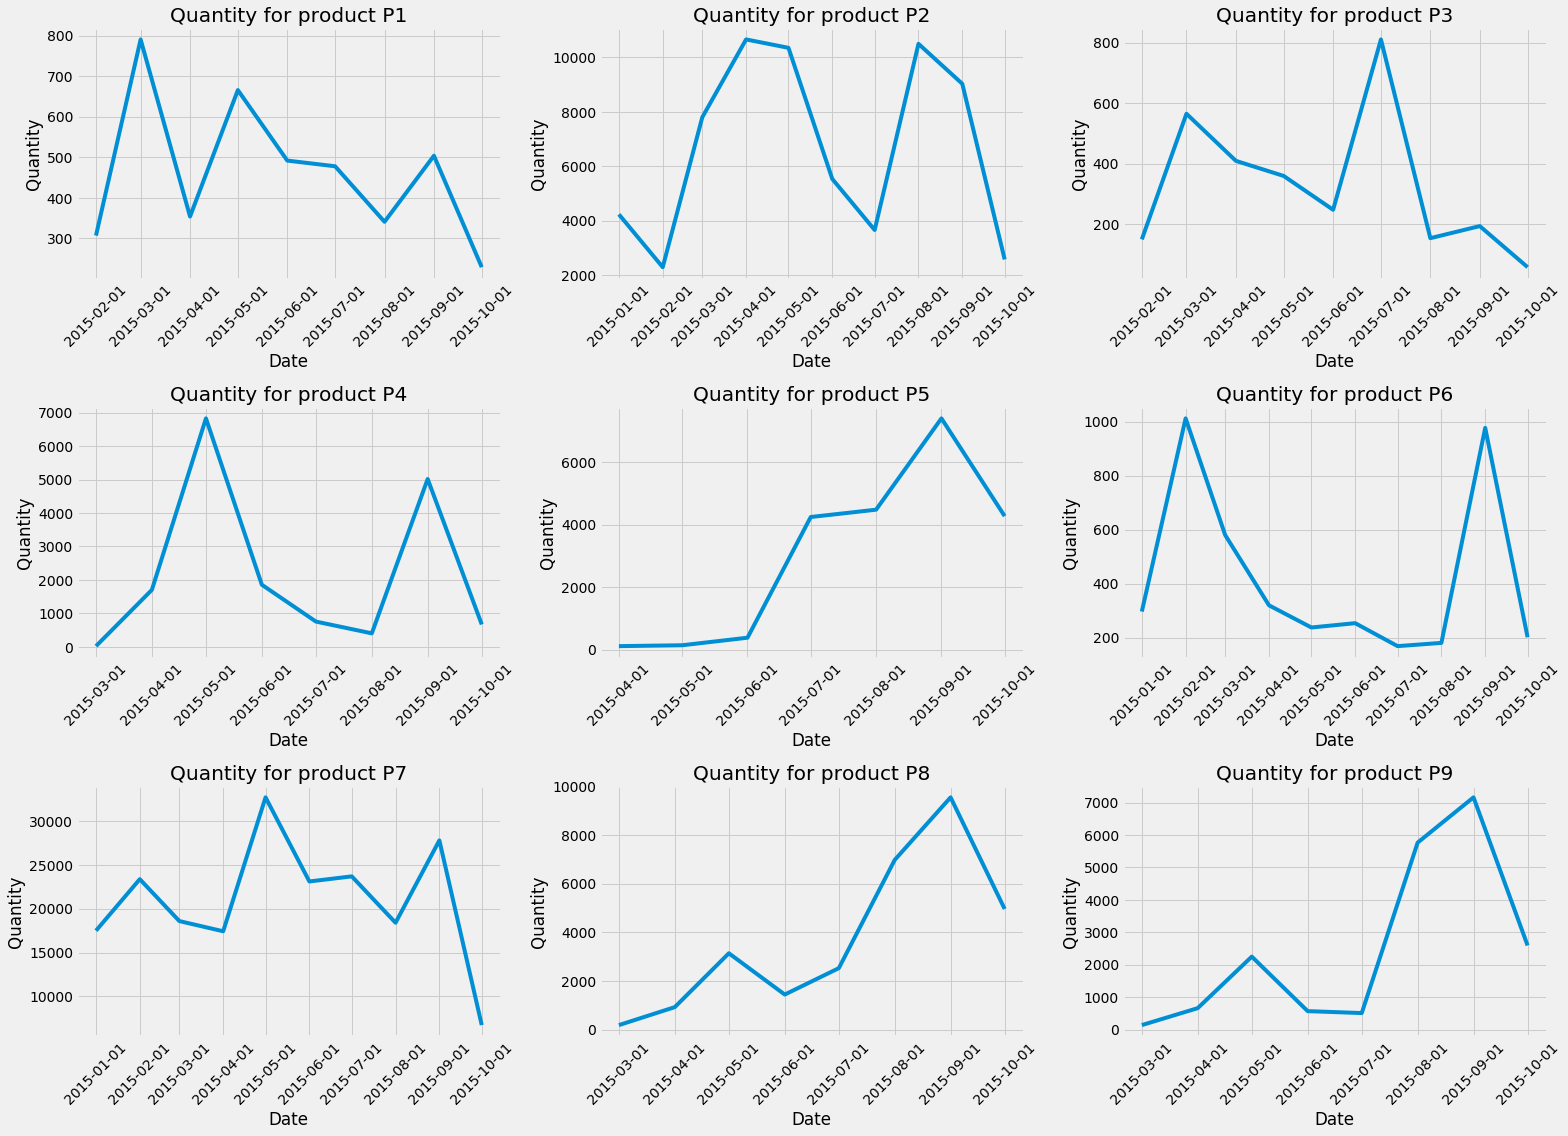

In [49]:
fig, ax = plt.subplots(nrows=3, ncols=3, figsize=(22, 16))

products = sales['prod_id'].sort_values().unique()
k = 0
for i in range(3):
    for j in range(3):
        ts = sales[sales['prod_id'] == products[k]]['qty_order']
        ts = ts.resample('MS').sum()
        
        ax[i,j].plot(ts.index, ts)
        ax[i,j].set_title('Quantity for product {}'.format(products[k]))
        ax[i,j].set_xlabel('Date')
        ax[i,j].set_ylabel('Quantity')
        ax[i,j].set_xticklabels(ts.index.astype(str), rotation=45)

        k+=1
            
        plt.tight_layout()

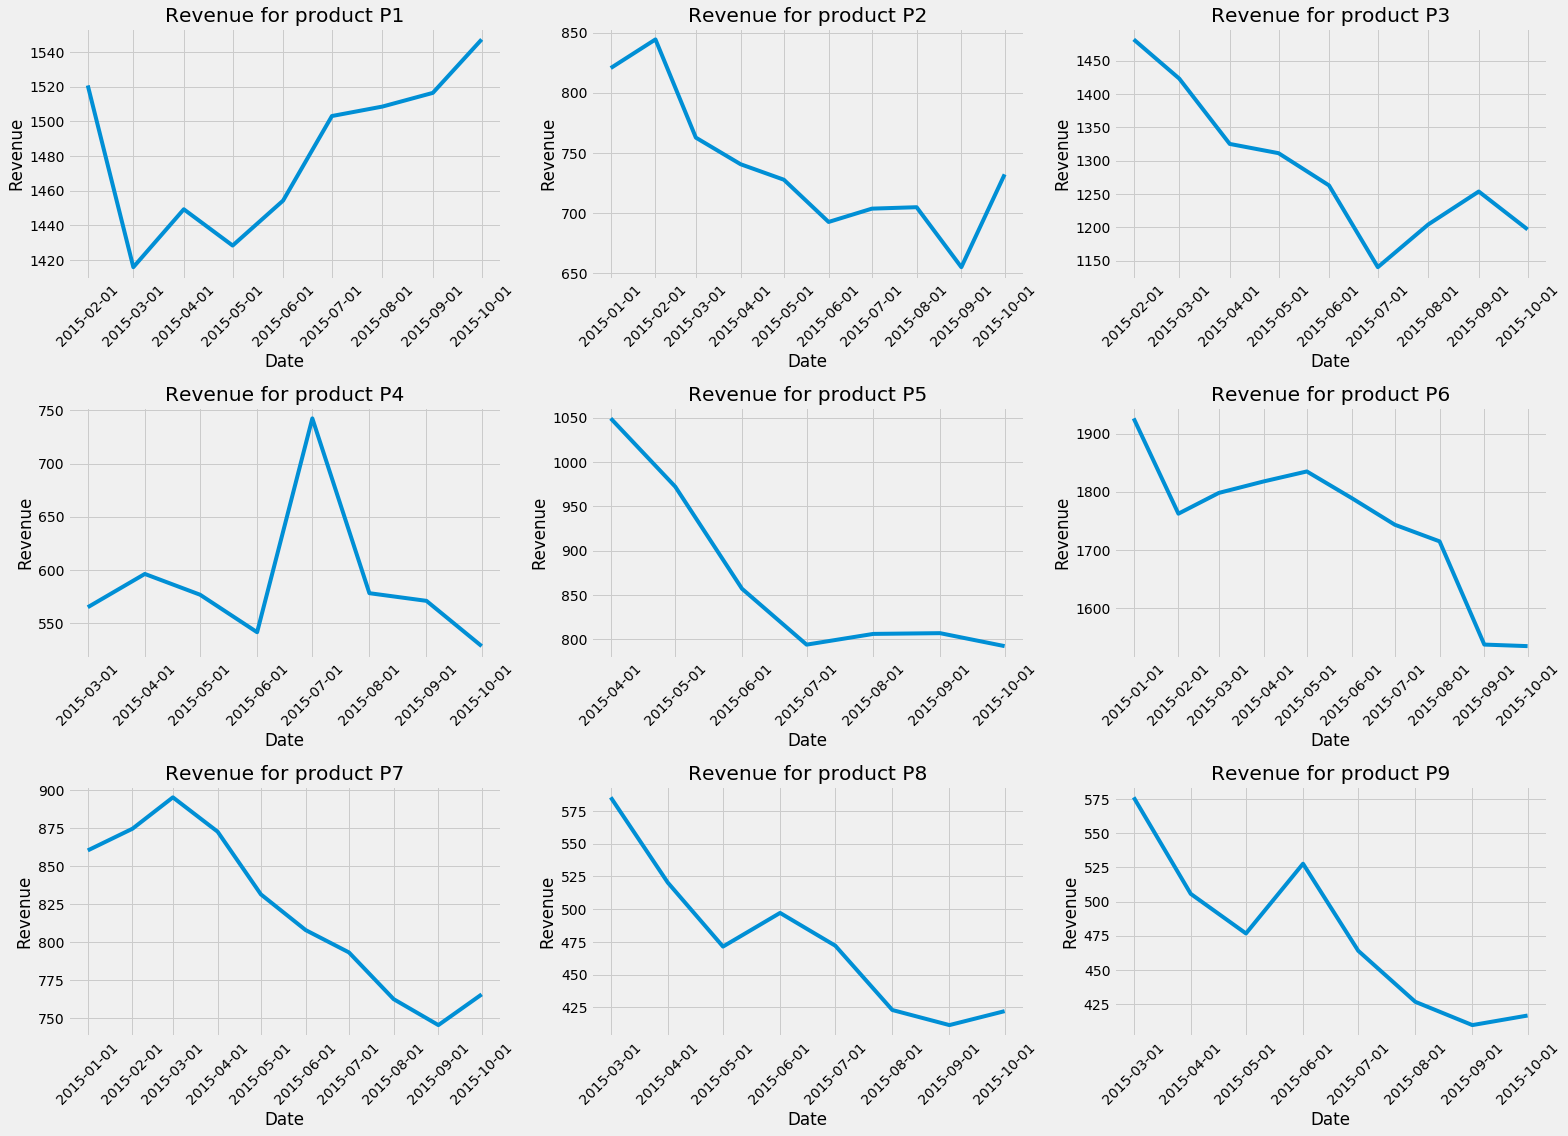

In [50]:
fig, ax = plt.subplots(nrows=3, ncols=3, figsize=(22, 16))

products = sales['prod_id'].sort_values().unique()
k = 0
for i in range(3):
    for j in range(3):
        ts = sales[sales['prod_id'] == products[k]]['revenue']
        ts = ts.resample('MS').mean()
        
        ax[i,j].plot(ts.index, ts)
        ax[i,j].set_title('Revenue for product {}'.format(products[k]))
        ax[i,j].set_xlabel('Date')
        ax[i,j].set_ylabel('Revenue')
        ax[i,j].set_xticklabels(ts.index.astype(str), rotation=45)
        
        k+=1
            
        plt.tight_layout()

As we can see there's a clearly tendency of decay on revenue on almost every product, excluding product P1.

Let's check now if the series is stationary, for stationary we mean that all the statistical properties(mean, variance and covariance) of out time series don't change over time. 
We want to check this because most of statistical forecasting methods assume that our data is stationary.

To do that we use a statistical hypothesis test called Dickey Fuller Test for stationarity.

In [51]:
def test_stationarity(ts):
    """
    Performs a dickey fuller test to check stationarity of a time series.
    
    param ts: Time series data
    return: Output of the test as a dataframe.
    
    """
#     print('Performing Dickey Fuller test..')
    dftest = adfuller(ts, autolag='AIC')
    dfoutput = pd.DataFrame(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'], columns=['Statistical Values'])
    
    for key, value in dftest[4].items():
        dfoutput.loc['Critical value {}'.format(key)] = value
    
    return dfoutput

In [52]:
output = test_stationarity(sales_per_day['qty_order'])
output

,Statistical Values
Test Statistic,-4.306
p-value,0.000
#Lags Used,13.000
Number of Observations Used,273.000
Critical value 1%,-3.455
Critical value 5%,-2.872
Critical value 10%,-2.572


As we can see, we have test statistics lower than the critical value for 1% so we can say with 99% of certainty that our series is stationary.

## Model:

In [571]:
def grouped_features(data):
    """
    This function creates some grouped features using the prices dataset.
    
    param data: Dataframe
    return data
    
    """
    data['competitor_price_per_prod'] = data['prod_id'].map(prices.groupby('prod_id')['competitor_price'].mean().to_dict())
    data['competitor_per_prod'] = data['prod_id'].map(prices.groupby('prod_id')['competitor'].count().to_dict())
    
    return data

def datetime_features(data):
    """
    This functions creates datetime features for the time series dataset.
    
    param data: time series data
    return data

    """
    data['sales_month'] = data.index.month
    data['sales_dayofweek'] = data.index.dayofweek
    data['sales_dayofyear'] = data.index.dayofyear
    data['sales_weekofyear'] = data.index.weekofyear
    
    return data

def difference_features(data, n):
    """
    This functions creates several features based on differences on quantity series.
    param data: time series data
    param n: number of features to create
    return: data
    
    """
    for s in range(1, n+1):
        data['quantity_diffs_{}'.format(s)] = data['qty_order'].diff(s)
    
    return data

def ts_train_test_split(data, target='qty_order', split_date='2015-09-14'):
    """
    This functions performs a train and test split on time series data.
    
    param data: Time series dataframe
    param target: Target to forecast
    param split_date: Date to split the dataset
    returns: Splitted dataset.
    
    """
    X = df.drop(target, axis=1)
    y = df[target]
    
    X_train, X_test = X[:split_date], X[split_date:]
    y_train, y_test = y[:split_date], y[split_date:]
    
    return X_train, X_test, y_train, y_test

Our goal is to forecast the products quantity over time. For simplicity I am going to forecast the quantity resampled by day and forecast in several windows of time, for example, 30, 60, 90 and 120 days in the future.

To evaluate our model I going to use the root mean squared erro(RMSE):

$RMSE = \sqrt\frac{\sum_{i=1}^{N}(true_i - pred_i)^2}{N}$

In [584]:
def rmse(true, predictions): 
    """
    This functions calculate the root mean squared error of a predictions
    
    param true: True values of the data
    param predictions: Predicted values
    return: RMSE
    
    """
    true = np.array(true)
    predictions = np.array(predictions)
    return mean_squared_error(true, predictions) ** 0.5

Let's start with some feature engineering. I will create some grouped features using the prices dataset.

Grouping the competitors' price by the products and counting the competitors' by product, and see with I can get some correlations with the target.

In [293]:
sales = grouped_features(sales)

Now doing the resample by day on our dataset we can create some datetime features, like month, day of sales and so on.

In [585]:
seed=42

In [618]:
dataframes = {}
for product in sales['prod_id'].sort_values().unique():
    df = sales[sales['prod_id'] == product]
    df = df.resample('D').agg({'qty_order': 'sum', 'revenue': 'mean', 'competitor_price_per_prod': 'mean', 'competitor_per_prod': 'mean'})
    df = datetime_features(df)
    df = difference_features(df, 20)
    df = df.fillna(0.0)
    dataframes[product] = df

In [649]:
results = []
for product, df in dataframes.items():
    result = pd.DataFrame([], columns=['mean', 'std'])
    for name, model in zip(names, models):
        score = timeseries_cv(model, df)
        result.loc[name] = [score.mean(), score.std()]
        results.append(result.sort_values(by='mean', ascending=False))

In [633]:
p7 = sales[sales['prod_id'] == 'P7']

In [634]:
df = p7.resample('D').agg({'qty_order': 'sum', 'revenue': 'mean', 'competitor_price_per_prod': 'mean', 'competitor_per_prod': 'mean'})

In [635]:
df = datetime_features(df)

In [636]:
df = difference_features(df, 20)

In [637]:
df.fillna(0.0, inplace=True)

In [638]:
X_train, X_test, y_train, y_test = ts_train_test_split(df)

In [639]:
lr = make_pipeline(RobustScaler(), LinearRegression(normalize=True))
lasso = make_pipeline(RobustScaler(), Lasso(alpha=0.0005, random_state=42))
knn = make_pipeline(RobustScaler(), KNeighborsRegressor(n_neighbors=3))
rf = RandomForestRegressor(n_estimators=1000, random_state=42)
xgboost = xgb.XGBRegressor(n_estimators=100, learning_rate=0.5, random_state=42)
lightgbm = lgb.LGBMRegressor(n_estimators=100, learning_rate=0.05, random_state=42)

models = [lr, lasso, knn, rf, xgboost, lightgbm]
names = ['Linear Regression', 'Lasso', 'KNN', 'Random Forest', 'XGBoost', 'LightGBM']

In [640]:
def timeseries_cv(model, data, n_splits=5):
    """
    This functions performs a cross validation on time series data with RMSE as scoring function.
    
    param model: Estimator
    param n_splits: splits to do on training data.
    return: Scores from cross validation.

    """
    X_train, X_test, y_train, y_test = ts_train_test_split(data)
    
    tscv = TimeSeriesSplit(n_splits=n_splits)
    scores = np.sqrt(-cross_val_score(estimator=model, X=X_train.values, y=y_train.values, cv=tscv, scoring='neg_mean_squared_error', n_jobs=-1))
    
    return scores

In [641]:
results = pd.DataFrame([], columns=['mean', 'std'])
for name, model in zip(names, models):
    score = timeseries_cv(model, df)
    results.loc[name] = [score.mean(), score.std()]

In [642]:
results.sort_values(by='mean', ascending=True).index[0]

'Linear Regression'

In [643]:
results.sort_values(by='mean', ascending=True)

,mean,std
Linear Regression,234.694,88.912
Random Forest,237.826,84.499
Lasso,244.334,66.502
XGBoost,301.853,66.013
KNN,336.769,88.637
LightGBM,367.874,119.706


We can see that Random Forest was the best model on cross validation with RMSE mean of 237.628. So I use it for making the forecast for 30 days into the future.

In [613]:
rf.fit(X_train, y_train)
predictions = rf.predict(X_test)

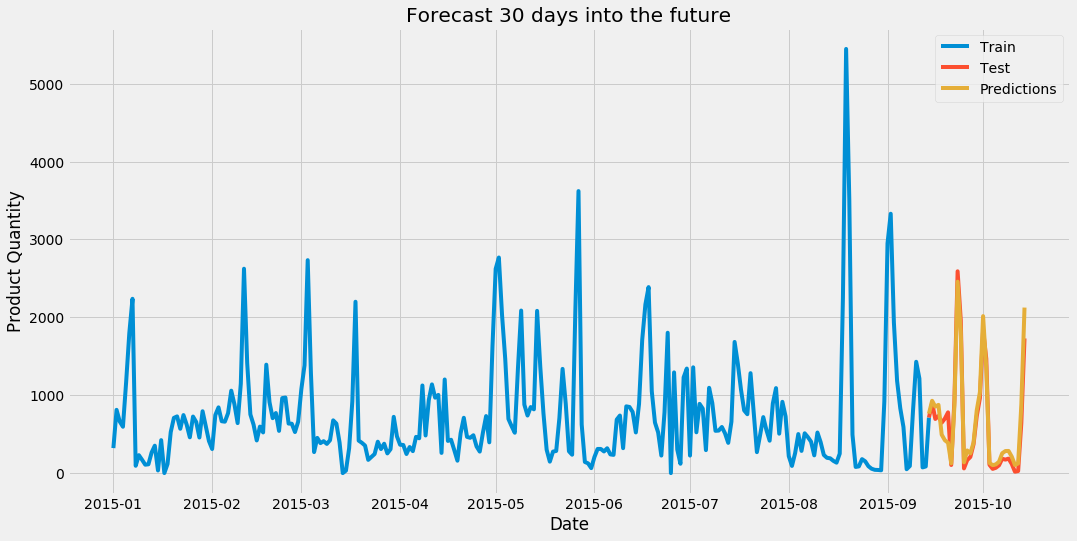

In [614]:
plt.plot(y_train)
plt.plot(y_test)
plt.plot(y_test.index, predictions)
plt.legend(['Train', 'Test', 'Predictions'])
plt.xlabel('Date')
plt.ylabel('Product Quantity')
plt.title('Forecast 30 days into the future');

In [615]:
def rmse(true, predictions): 
    """
    This functions calculate the root mean squared error of a predictions
    
    param true: True values of the data
    param predictions: Predicted values
    return: RMSE
    
    """
    true = np.array(true)
    predictions = np.array(predictions)
    return mean_squared_error(true, predictions) ** 0.5

def mape(true, predictions): 
    """
    This functions calculate the mean absolute percentage error.
    
    param true: True values of the data
    param predictions: Predicted values
    return: MAPE
    
    """
    true = np.array(true)
    predictions = np.array(predictions)    
    return np.mean(np.abs((true - predictions)) / true) * 100

def smape(true, predictions):
    """
    This functions calculate the symmetric mean absolute percentage error
    
    param true: True values of the data
    param predictions: Predicted values
    return: sMAPE
    
    """
    
    true = np.array(true)
    predictions = np.array(predictions)
    
    return np.mean(np.abs(true - predictions) * 2/ (np.abs(true) + np.abs(predictions))) * 100

def metrics(true, predictions):
    """
    This functions calculate several metrics of a regression problem.
    
    param true: True values of the data
    param predictions: Predicted values
    return: Metrics dataframe with all metrics of interest.
    
    """
    metrics = pd.DataFrame(columns=['Metric Value'])
    metrics.loc['MAE'] = mean_absolute_error(true, predictions)
    metrics.loc['RMSE'] = rmse(true, predictions)
    metrics.loc['R2'] = r2_score(true, predictions)
    metrics.loc['MAPE'] = mape(true, predictions)
    metrics.loc['sMAPE'] = smape(true, predictions)
    
    return metrics

In [616]:
metrics(y_test, predictions)

,Metric Value
MAE,117.347
RMSE,150.100
R2,0.947
MAPE,59.471
sMAPE,35.301
